In [1]:
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install opencv-python

In [3]:
import cv2

Number of object detected: 6


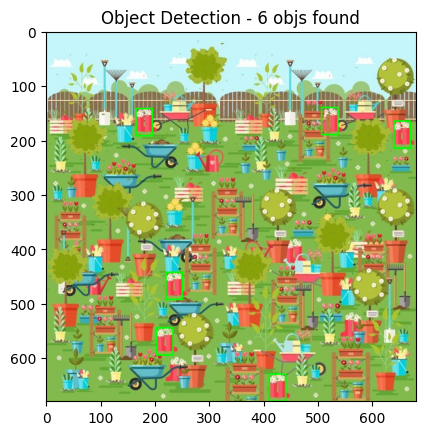

In [36]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def compute_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two boxes.
    Each box is represented by a tuple (x1, y1, x2, y2).
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Compute the area of intersection rectangle
    inter_area = max(0, x2_inter - x1_inter + 1) * max(0, y2_inter - y1_inter + 1)

    # Compute the area of both bounding boxes
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Compute the IoU
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

def non_max_suppression(boxes, iou_threshold=0.1):
    """
    Perform Non-Maximum Suppression (NMS) to remove overlapping boxes.
    boxes: list of (x1, y1, x2, y2)
    iou_threshold: IoU threshold for suppressing boxes
    """
    if len(boxes) == 0:
        return []

    # Convert boxes to array and sort by the bottom-right y-coordinate (y2)
    boxes = np.array(boxes)
    sorted_indices = np.argsort(boxes[:, 3])

    keep = []

    while len(sorted_indices) > 0:
        # Pick the box with the largest bottom-right corner and remove it from the list
        current = sorted_indices[-1]
        keep.append(current)
        sorted_indices = sorted_indices[:-1]

        suppressed_indices = []
        for i in sorted_indices:
            iou = compute_iou(boxes[current], boxes[i])
            if iou > iou_threshold:
                suppressed_indices.append(i)

        # Remove suppressed indices from the sorted list
        sorted_indices = np.setdiff1d(sorted_indices, suppressed_indices)

    return boxes[keep].astype(int)

# Load the main image and convert it to grayscale
main_image = cv2.imread('/content/Counting/pair_boot.jpg')
main_image_gray = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
main_image_gray = cv2.equalizeHist(main_image_gray)

# Load the template image and convert it to grayscale
template = cv2.imread('/content/ctemplate/template5.jpg')
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
template = cv2.equalizeHist(template)
w, h = template.shape[::-1]

# Apply template matching using the cv2.matchTemplate function
result = cv2.matchTemplate(main_image_gray, template, cv2.TM_CCOEFF_NORMED)

# Set a threshold to detect matches
threshold = 0.6 # Adjust based on how close the template matches should be
loc = np.where(result >= threshold)

# Collect all bounding boxes (x1, y1, x2, y2)
boxes = []
for pt in zip(*loc[::-1]):
    boxes.append((pt[0], pt[1], pt[0] + w, pt[1] + h))

# Apply Non-Maximum Suppression to remove overlapping boxes
nms_boxes = non_max_suppression(boxes, iou_threshold=0.001)

# Draw rectangles around detected objs after NMS
for (x1, y1, x2, y2) in nms_boxes:
    cv2.rectangle(main_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Count how many matches were found after NMS
num_objs = len(nms_boxes)
print(f'Number of object detected: {num_objs}')

# Show the image with rectangles drawn
plt.imshow(cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB))
plt.title(f'Object Detection - {num_objs} objs found')
plt.show()